# Final Project: Estimating the Hurst Parameter with Visibility Graphs to measure Long Memory in Time Series

**Author**: Joseph Dasenbrock

**Abstract**

Time series analysis is dominated by the class of ARMA models, which model future values of the series as function of recent past values of the series. While these models have been successful in application, ARMA models have limitations founded in the assumptions being made about the nature of the underlying process. Time series analysis based on graphs (i.e. networks) offer potential for modeling which makes less strict assumptions, and opens up time series analysis to the rich mathematical toolset available to networks. The visibility graph is introduced and explored as one way to model a time series as a network. To exemplify the utility of such a model, the visibility graph is applied to the analysis of long memory in time series. A time series which possesses long memory is one which is significantly dependent on the entiriety of the history of the series, not just the most recent values. Long memory is introduced and visibility graphs are utilized to estimate the Hurst parameter and differentiate between simulated time series which exhibit long memory and series that do not exhibit such as property.

# Introduction



Among the most common tools for time series analysis is the AutoRegressive Moving Average model (ARMA). This class of models treats a time series as random process where future values are dependent on some small number of recent values of the series itself plus some number of recent values of the "white noise" in the time series. There are many different forms and variants of such models, however below is one common form ([1]): 

$$
\def \a {\alpha}
r_t = \phi_0 + \sum_{i=1}^{p} \phi_i r_{t-i} + \a_{t} - \sum_{i=1}^{q}\theta_i \a_{t-i}
$$

...where $p$ and $q$ are nonnegative integers, $r_i$ is the time series, and $\{\alpha_i\}$ is a white noise series derived from the time series.

While the ARMA class of models have been successfully used across many domains, these models have important limitations.

One of the most notable such limitations is the requirement that the modeled time series is stationary, i.e. the mean value of the series is the same over time. Clearly, real-world processes often do not have such a characteristic; any sampling of real-world time series can verify this (e.g. weekly rainfall totals, financial time series or bird population levels by geography are all time series not likely to exhibit stationarity). 

Often, time series can be converted to a stationary series with relatively simple adjustments, such as modeling the difference between the series and a choice of a trend model, or by modeling the period-to-period change in the series instead of the series itself. However, these adjustments can become onerous in implementation and are sometimes insufficient. For example, the level of deviation from the trend or the period-to-period differences can also fail to be stationary. 

Fundamental to such problems and others not mentioned here is that the ARMA model makes an assumption about the underlying nature of the time series process, i.e. that the future values of the series are determined by the most recent $p$ values of the series and the most recent $q$ values of the white noise process that is derived from the series. 

The ARMA model makes a possibly incorrect assumption about the underlying process, and it also offers little utility beyond merely forecasting future values of the series. There does not exist a rich set of properties of a time series that can be estimated utilizing the ARMA model, ARMA merely models the relationship between recent values of the series and the next value.

Translation of a time series into a graph (network) would offer advantages over the ARMA model as described here - a network would likely capture more of the idiosyncratic features of the data itself, instead of attempting to force the data into a certain framework. Also, translation of the series to a graph would make available the rich mathematical toolset available to graphs, and therefore more useful information could be extracted from the data. 

# Fractional Brownian Motion and the Hurst Parameter

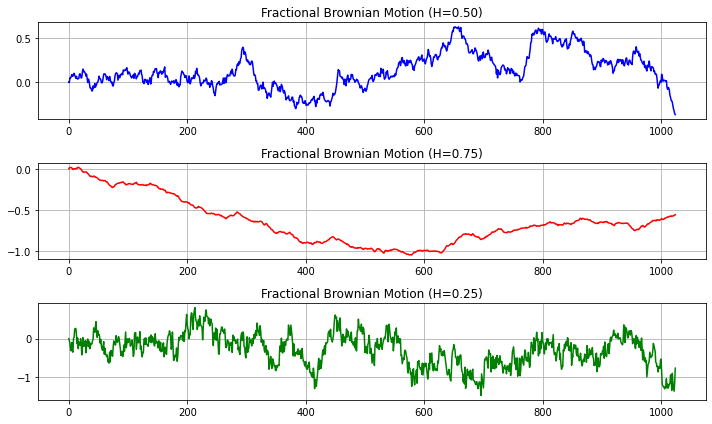

In [1]:
from matplotlib import pyplot as plt
# see source or https://pypi.org/project/fbm/
from src.fbm.fbm import FBM

f = lambda hurst: FBM(n=1024, hurst=hurst, length=1, method='daviesharte').fbm()

fig = plt.figure(figsize=(10,6))

def add(ax, hurst=0.5, color='blue'):
    y = f(hurst)
    ax.plot(range(len(y)), y, color=color)
    plt.grid()
    ax.set(title=f'Fractional Brownian Motion (H={hurst:.2f})')
    
ax1 = fig.add_subplot(311)
add(ax1, hurst=0.5)

ax2 = fig.add_subplot(312)
add(ax2, hurst=0.75, color='red')

ax3 = fig.add_subplot(313)
add(ax3, hurst=0.25, color='green')

plt.tight_layout()

# References

[1] Tsay, Ruey S. Analysis of Financial Time Series, Third Edition. 3rd ed. Wiley Series in Probability and Statistics. Hoboken, NJ: Wiley, 2010.

    
[2]: Graves, T., Gramacy, R., Watkins, N., Franzke, C. (2017). A Brief History of Long Memory: Hurst, Mandelbrot and the Road to ARFIMA, 1951–1980 Entropy https://dx.doi.org/10.3390/e19090437


[3]: Davies, R., Harte, D. (1987). Tests for Hurst Effect Biometrika  74(1), 95. https://dx.doi.org/10.2307/2336024


[4]: Lo, A. (1991). Long-Term Memory in Stock Market Prices Econometrica  59(5), 1279. https://dx.doi.org/10.2307/2938368


[5]: Lacasa, L., Luque, B., Luque, J., Nuño, J. (2009). The visibility graph: A new method for estimating the Hurst exponent of fractional Brownian motion EPL  86(3), 30001. https://dx.doi.org/10.1209/0295-5075/86/30001


[6]: Lacasa, L., Luque, B., Ballesteros, F., Luque, J., Nuño, J. (2008). From time series to complex networks: The visibility graph Proceedings of the National Academy of Sciences  105(13), 4972-4975. https://dx.doi.org/10.1073/pnas.0709247105


[7]: Lacasa, L., Nicosia, V., Latora, V. (2015). Network structure of multivariate time series Scientific Reports  5(1), 15508. https://dx.doi.org/10.1038/srep15508